---
# Simulate ISIs for experiment

The goal of this notebook is to find a strategy in which we find an optimal set of inter-stimulus intervals for the Hole-Response experiment. Here, we've simulated the response of a target pRF to full-field stimulus minus a mask to maximize suppression, as well as to growing stimuli to find a stimulus that maximizes a positive response. Here, we'll use the stimulus sizes for both to recreate a design matrix which we'll feed into the pRF estimates of the target

In [1]:
from linescanning import (
    prf,
    utils,
    plotting,
    dataset,
    simulate
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
import os
opj = os.path.join

In [62]:
subject = "sub-005"
hemi = "L"
proj_dir = os.environ.get("DIR_DATA_HOME")
prf_file = opj(
    proj_dir, 
    "derivatives", 
    "pycortex", 
    subject, 
    f"{subject}_model-norm_desc-best_vertices.csv")

pars = pd.read_csv(prf_file).set_index(["hemi"])
pars

,x,y,prf_size,prf_ampl,bold_bsl,surr_ampl,surr_size,neur_bsl,surr_bsl,A,...,ratio (B/D),r2,size ratio,suppression index,ecc,polar,index,position,normal,stim_sizes
hemi,,,,,,,,,,,,,,,,,,,,,
L,1.421768,-0.278521,0.708782,23.029460,0.0,1.463853,5.037563,23.056306,99.998744,23.029460,...,0.230566,0.760695,7.107356,3.210923,1.448792,-0.193448,4387,[-24.32088 -85.042816 -20.89439 ],[-0.60315324 -0.63437336 0.4835045 ],"[2.030456640472164, 5.637966982281929]"
R,-0.744468,-0.238456,0.698004,101.423294,0.0,2.270485,5.101513,101.443356,99.992125,101.423294,...,1.014513,0.793326,7.308720,1.195814,0.781725,-2.831614,311352,[ 7.3705754 -85.45827 -16.151464 ],[-0.69562674 0.69457237 0.18350114],[1.833 5.559]


In [3]:
# set screen information
screen_distance_cm = 196
screen_size_cm_x = 69.8
screen_size_cm_y = 38.9

# define visual field in degree of visual angle
ss_deg_x = 2*np.degrees(np.arctan(screen_size_cm_x/(2.0*screen_distance_cm)))
x = np.linspace(-ss_deg_x/2, ss_deg_x/2, 1920)

ss_deg_y = 2*np.degrees(np.arctan(screen_size_cm_y/(2.0*screen_distance_cm)))
y = np.linspace(-ss_deg_y/2, ss_deg_y/2, 1080)

# define visual extent:
x_ext = [-ss_deg_x/2,ss_deg_x/2]
y_ext = [-ss_deg_y/2,ss_deg_y/2]
vf_extent = (x_ext,y_ext)
vf_extent

([-10.096339969824111, 10.096339969824111],
 [-5.667175191697089, 5.667175191697089])

In [4]:
# make stimuli
stims_full, sizes_full = prf.make_stims(
    (x,y), 
    factor=2, 
    dt="fill")

stims_hole, sizes_hole = prf.make_stims(
    (x,y), 
    factor=2, 
    dt="hole")

In [5]:
# fetch stimulus sizes
stim_sizes = utils.string2float(pars["stim_sizes"][hemi])
stim_sizes

array([2.03045664, 5.63796698])

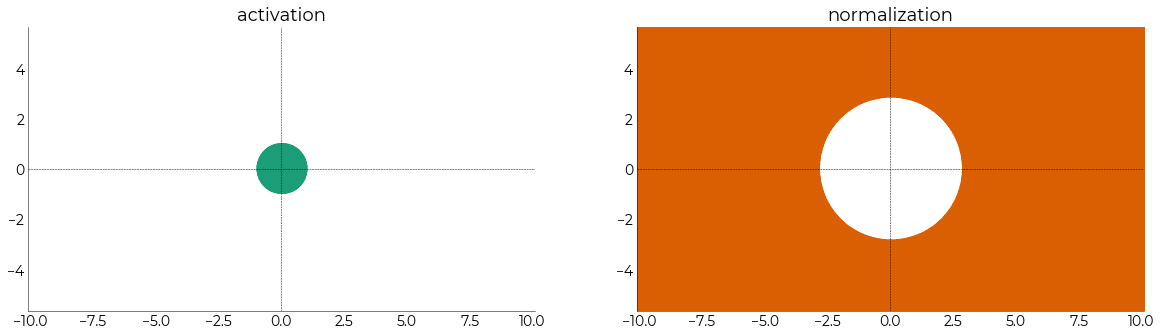

In [7]:
%matplotlib inline
# plot
cols = ["#1B9E77","#D95F02"]


fig,axs = plt.subplots(ncols=2, figsize=(20,6))
stims = []
for x,(ii,stim,nn) in enumerate(zip(stim_sizes, [sizes_full,sizes_hole],["activation","normalization"])):
    
    ix = utils.find_nearest(stim, ii)[0]
    img = stims_full[ix]
    cmap = utils.make_binary_cm(cols[x])

    if nn == "normalization":
        tmp = np.ones_like(img)
        tmp[img>0] = 0
        img = tmp.copy()
        
    axs[x].imshow(img, cmap=cmap, extent=vf_extent[0]+vf_extent[1])
    axs[x].axvline(0, color='k', linestyle='dashed', lw=0.5)
    axs[x].axhline(0, color='k', linestyle='dashed', lw=0.5)
    axs[x].set_title(nn)
    
    plotting.conform_ax_to_obj(ax=axs[x])
    stims.append(img)
    # axs.axis('off')

In [8]:
# settings
settings_path = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/LineExps/ActNorm/settings.yml"
with open(settings_path, 'r', encoding='utf8') as f_in:
    settings = yaml.safe_load(f_in)

TR = 0.105
osf = 1000
n_trials        = settings['design'].get('n_trials')
stim_duration   = settings['design'].get('stim_duration')
start_duration  = settings['design'].get('start_duration')
end_duration    = settings['design'].get('end_duration')
theor_total_duration = 420 #s -> 7 minutes 
print(n_trials)

32


In [41]:
iti_obj = simulate.ITI(
    tmin=settings['design'].get('minimal_iti_duration'),
    tmax=settings['design'].get('maximal_iti_duration'),
    tmean=settings['design'].get('mean_iti_duration'),
    n_trials=n_trials,
    leeway=settings['design'].get('total_iti_duration_leeway'),
    stim_duration=stim_duration,
    total_duration=theor_total_duration,
    start_duration=start_duration,
    end_duration=end_duration,
    verbose=True,
    events=["act","norm"]
)

ITIs created with total ITI duration of 193.18s after 2 iterations
Total experiment time: 297.18s (= 2830 samples)


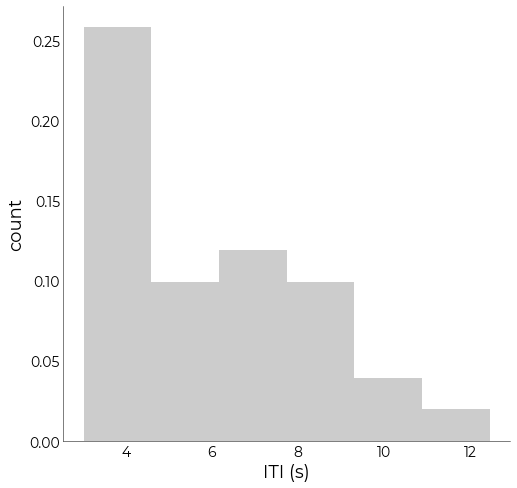

In [42]:
iti_obj.plot_iti_distribution()

In [46]:
# initiate empty design
n_samples = round(iti_obj.total_experiment_time/TR)
dm = np.zeros((*img.shape, n_samples))

iti_obj.get_onsets().tail()

onset  duration
subject run event_type                      
1       1   act         244.968379       2.0
            act         251.934237       2.0
            norm        263.927868       2.0
            norm        270.162360       2.0
            norm        275.182903       2.0

In [49]:
dm = iti_obj.create_prf_design(
    iti_obj,
    stims=stims,
    make_square=True)

dm.shape

(270, 270, 2830)

In [67]:
# initialize object without actual data; mainly insert design matrix
obj_ = prf.pRFmodelFitting(
    None,
    design_matrix=dm,
    TR=TR,
    verbose=True
)

# set position to 0 and parse parameters into array
insert_pars = pars.copy()
for ii in ["x","y"]:
    insert_pars[ii] = 0

l_pars = prf.Parameters(insert_pars, model="norm").to_array()
obj_.load_params(l_pars, model="norm", stage="iter")

Reading settings from '/data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/misc/prf_analysis.yml'
Instantiate HRF with: [1, 1, 0] (fit=False)
Using constraint(s): ['tc', 'tc']
Inserting parameters from <class 'numpy.ndarray'> as 'norm_iter' in <linescanning.prf.pRFmodelFitting object at 0x7f064955cdc0>


Variance = 2.81


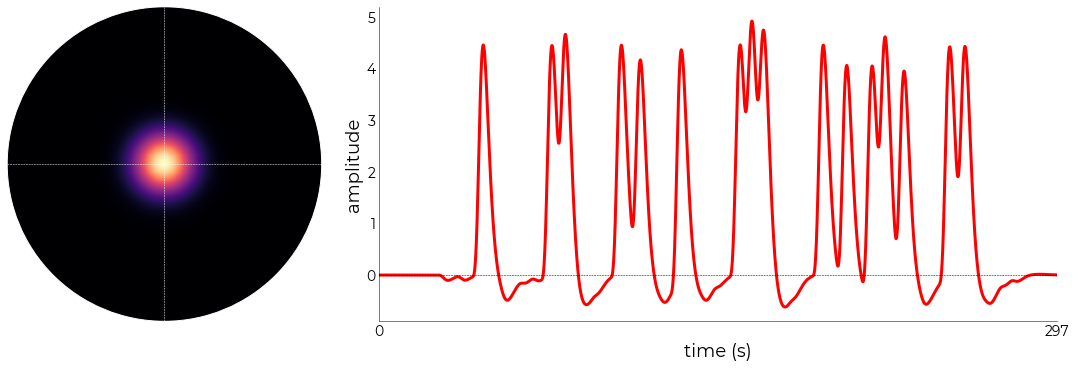

In [70]:
# get timecourse + make plot
_,_,_,tc = obj_.plot_vox(
    vox_nr=0,
    title="pars", 
    model="norm")

# get variance
tc_var = np.var(tc)
print(f"Variance = {round(tc_var,2)}")